In [1]:
from fastai.vision.all import *

In [2]:
path = Path('/kaggle/input/cassava-leaf-disease-classification/')
path.ls()

(#7) [Path('/kaggle/input/cassava-leaf-disease-classification/train_tfrecords'),Path('/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv'),Path('/kaggle/input/cassava-leaf-disease-classification/test_tfrecords'),Path('/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json'),Path('/kaggle/input/cassava-leaf-disease-classification/train_images'),Path('/kaggle/input/cassava-leaf-disease-classification/train.csv'),Path('/kaggle/input/cassava-leaf-disease-classification/test_images')]

In [3]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
with open(path/'label_num_to_disease_map.json') as f:
    label_dict = json.load(f)

label_dict = {int(k):v for k,v in label_dict.items()}

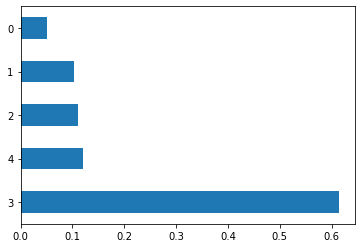

In [5]:
train_df['label'].value_counts(normalize=True).plot(kind='barh')

In [6]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
splits = {}

for i,(tr_idx,val_idx) in enumerate(cv.split(train_df, train_df['label'])):
    splits[i] = [tr_idx, val_idx]

In [7]:
df = train_df.set_index('image_id')
labels = df.to_dict()['label']

In [8]:
%%time
labels['1000723321.jpg']

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


1

In [9]:
def get_label(labels, x):
    x = Path(x)
    return labels[x.name]

In [10]:
fn = train_df.iloc[0,0]

In [11]:
%%time
get_label(labels,path/'train_images'/fn)

CPU times: user 43 µs, sys: 10 µs, total: 53 µs
Wall time: 56.7 µs


0

In [12]:
def get_splits(FOLD, x):
    return splits[FOLD]

In [13]:
def get_data(labels,split,bs=64, presize=500, resize=384):
    tfms = [Rotate(90), Warp(magnitude=0.4, p=1.),Zoom(min_zoom=0.9, max_zoom=1.3), Brightness(max_lighting=0.5), Flip(), Contrast(), Resize(resize)]
    comp = setup_aug_tfms(tfms)
    return DataBlock(blocks=(ImageBlock, CategoryBlock),
        get_items=lambda p: get_image_files(p),
        get_y=partial(get_label, labels),
        splitter=partial(get_splits, split),
        item_tfms=[Resize(presize)],
        batch_tfms=[*comp, Normalize.from_stats(*imagenet_stats)]).dataloaders(path/'train_images',bs=bs,num_workers=8)

In [14]:
N_FOLDS=5

In [15]:
os.makedirs('/root/.cache/torch/hub/checkpoints/', exist_ok=True)

In [16]:
!cp /kaggle/input/fastai-pretrained/resnet50-19c8e357.pth /root/.cache/torch/hub/checkpoints/

In [17]:
for split in range(N_FOLDS):
    dls = get_data(labels,split,bs=64)
    learn = cnn_learner(dls, models.resnet50, metrics=[accuracy]).to_fp16()
    learn.freeze()
    # learn.lr_find()
    learn.fit_one_cycle(10, 5e-3, cbs=[MixUp()])
    learn.save(f'resnet50-frozen-fold_{split}')
    learn.unfreeze()
    learn.fit_one_cycle(10, slice(1e-5, 1e-4), cbs=[MixUp()])
    learn.save(f'resnet50-full-fold_{split}')

epoch,train_loss,valid_loss,accuracy,time
0,1.170610,0.577914,0.810981,07:07
1,0.856520,0.542759,0.816355,07:05
2,0.788369,0.521264,0.819860,07:04
3,0.741200,0.466948,0.840421,07:03
4,0.714136,0.421038,0.860514,07:04
5,0.675217,0.430839,0.849766,07:04
6,0.660849,0.374984,0.879673,07:05
7,0.646018,0.361216,0.881308,07:04
8,0.627416,0.344165,0.887383,07:03
9,0.622094,0.344613,0.886215,07:07


epoch,train_loss,valid_loss,accuracy,time
0,0.647621,0.346684,0.885981,08:37
1,0.634245,0.354095,0.883178,08:36
2,0.631346,0.347436,0.885047,08:36
3,0.611598,0.347708,0.885047,08:37
4,0.605712,0.344413,0.886916,08:36
5,0.621895,0.340230,0.890187,08:40
6,0.605411,0.333552,0.888318,08:44
7,0.599786,0.333086,0.889953,08:45
8,0.598399,0.329405,0.889720,08:47
9,0.582452,0.329834,0.889953,08:47


epoch,train_loss,valid_loss,accuracy,time
0,1.195890,0.661991,0.775467,07:14
1,0.830050,0.548886,0.825701,07:12
2,0.788095,0.463350,0.832944,07:14
3,0.741852,0.502649,0.823832,07:09
4,0.710805,0.383854,0.870093,07:07
5,0.697639,0.394302,0.869159,07:12
6,0.663490,0.349942,0.880607,07:12
7,0.650956,0.331205,0.891122,07:13
8,0.632861,0.331051,0.888551,07:14
9,0.621094,0.320510,0.892991,07:17


epoch,train_loss,valid_loss,accuracy,time
0,0.612215,0.330968,0.889252,08:45
1,0.639734,0.327978,0.890421,08:41
2,0.639782,0.323672,0.889252,08:40
3,0.613954,0.335089,0.885047,08:38
4,0.621564,0.325677,0.888785,08:38
5,0.609910,0.315922,0.893224,08:37
6,0.599206,0.318330,0.894860,08:36
7,0.593031,0.311455,0.898131,08:36
8,0.582889,0.306233,0.898598,08:36
9,0.596752,0.309305,0.896963,08:36


epoch,train_loss,valid_loss,accuracy,time
0,1.163901,0.632158,0.794344,07:09
1,0.806746,0.572892,0.807198,07:04
2,0.783145,0.542671,0.808834,07:07
3,0.742195,0.563653,0.816312,07:06
4,0.715146,0.497061,0.827530,07:06
5,0.686530,0.429154,0.854873,07:06
6,0.655613,0.378320,0.870764,07:06
7,0.647664,0.375353,0.872166,07:08
8,0.635530,0.361685,0.878944,07:08
9,0.616089,0.358383,0.878243,07:06


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 15.90 GiB total capacity; 14.65 GiB already allocated; 63.75 MiB free; 15.00 GiB reserved in total by PyTorch)